<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.2/MLP-Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP(Multi Layer Perceptron) - Regression

- CH.1에서 사용했던 Marketing.csv 파일 사용

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

[1] Data Processing

In [3]:
# 파일 불러오기
train_data_url = "/content/drive/MyDrive/DL 실습/marketing.csv"
df = pd.read_csv(train_data_url)
print (df.shape) # 파일 형식 확인
df

(200, 4)


,youtube,facebook,newspaper,sales
0,276.12,45.36,83.04,26.52
1,53.40,47.16,54.12,12.48
2,20.64,55.08,83.16,11.16
3,181.80,49.56,70.20,22.20
4,216.96,12.96,70.08,15.48
...,...,...,...,...
195,45.84,4.44,16.56,9.12
196,113.04,5.88,9.72,11.64
197,212.40,11.16,7.68,15.36
198,340.32,50.40,79.44,30.60


In [4]:
# X값 coulumn
x = df.drop(["sales"], axis=1) 

# y값 column
y = df["sales"]

print(x.shape)
print(y.shape)
print(type(y))

(200, 3)
(200,)
<class 'pandas.core.series.Series'>


In [5]:
#학습데이터와 테스트데이터를 일정비율로 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=1234)

#학습 데이터
print("x_train의 크기: ",x_train.shape)
print("y_train의 크기: ",y_train.shape,'\n')

#테스트 데이터 
print("x_test의 크기: ",x_test.shape)
print("y_test의 크기: ",y_test.shape)
print(type(y_train))

x_train의 크기:  (140, 3)
y_train의 크기:  (140,) 

x_test의 크기:  (60, 3)
y_test의 크기:  (60,)
<class 'pandas.core.series.Series'>


In [6]:
#학습 데이터 Scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scale = scaler.transform(x_train) # x_train_scale은 numpy ndarray 


#테스트 데이터 Scaling
x_test_scale = scaler.transform(x_test) # x_test_scale은 numpy ndarray 


# Array-->Tensor
x_train_tensor = torch.FloatTensor(x_train_scale)
y_train_tensor = torch.FloatTensor(y_train.values) #y_train은 판다스 Series이므로 values를 사용해서 numpy ndarray로 가져오기

x_test_tensor = torch.FloatTensor(x_test_scale)
y_test_tensor = torch.FloatTensor(y_test.values)

In [7]:
#학습 데이터 배치화 시키기 
train_data = data_utils.TensorDataset(x_train_tensor, y_train_tensor)

dataloader = data_utils.DataLoader(train_data, batch_size=32, shuffle=True , drop_last=True)


#배치화된 데이터 확인
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape)  # x_train 
    print(datas[1].shape) # y_train
    break

0
torch.Size([32, 3])
torch.Size([32])


[2] Model

In [8]:
class MLP_model(torch.nn.Module):
        def __init__(self, input_size, hidden_size ,output_size):
            super(MLP_model, self).__init__()
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.hidden2 = 16
            
            #MLP이기 때문에 여러 개의 함수 필요 이때 변수 값 주의
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden2)
            self.fc3 = torch.nn.Linear(self.hidden2, self.output_size)
            self.relu = torch.nn.ReLU()
            self.sig = torch.nn.Sigmoid()
            
        def forward(self, x):
            fc1 = self.fc1(x)
            ac1 = self.relu(fc1)
            fc2 = self.fc2(ac1)
            ac2 = self.relu(fc2)
            fc3 = self.fc3(ac2)


            return fc3

In [9]:
#Parameter 정의
input_dim = 3
output_dim = 1
hidden_dim = 32 #대체로 2의 배수로 사용
learning_rate = 0.01
n_epochs = 700

#model 생성
model = MLP_model(input_size = input_dim, hidden_size = hidden_dim, output_size = output_dim)

In [10]:
#손실함수 생성
criterion = torch.nn.MSELoss()
#Optimizer 생성
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

[3] Training

In [11]:
train_loss = []
test_loss = []

for epoch in range(n_epochs+1):
    
    #Batch 학습
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad() #gradient 값 초기화
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1)
        loss_train = criterion(y_pred, y_batch)
        loss_train.backward()
        optimizer.step()
        
        #Validation
        y_test_pred = model(x_test_tensor)
        y_test_pred = y_test_pred.reshape(-1) #차원을 맞춰야 loss값을 정확히 알 수 있음
        loss_test = criterion(y_test_pred, y_test_tensor)

    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format( epoch, train_loss[-1], test_loss[-1]))

epoch:0, Loss_train:234.83, Loss_test:126.71
epoch:1, Loss_train:17.79, Loss_test:21.95
epoch:2, Loss_train:40.39, Loss_test:57.63
epoch:3, Loss_train:10.58, Loss_test:4.73
epoch:4, Loss_train:7.50, Loss_test:6.38
epoch:5, Loss_train:21.52, Loss_test:12.97
epoch:6, Loss_train:27.88, Loss_test:15.52
epoch:7, Loss_train:37.22, Loss_test:18.34
epoch:8, Loss_train:3.31, Loss_test:3.82
epoch:9, Loss_train:5.50, Loss_test:7.51
epoch:10, Loss_train:33.40, Loss_test:11.61
epoch:11, Loss_train:16.99, Loss_test:11.85
epoch:12, Loss_train:10.66, Loss_test:12.73
epoch:13, Loss_train:8.75, Loss_test:10.63
epoch:14, Loss_train:6.10, Loss_test:6.73
epoch:15, Loss_train:3.69, Loss_test:6.35
epoch:16, Loss_train:5.59, Loss_test:8.34
epoch:17, Loss_train:15.79, Loss_test:11.61
epoch:18, Loss_train:7.30, Loss_test:7.19
epoch:19, Loss_train:2.68, Loss_test:5.32
epoch:20, Loss_train:10.80, Loss_test:6.92
epoch:21, Loss_train:20.00, Loss_test:10.18
epoch:22, Loss_train:22.93, Loss_test:9.14
epoch:23, Loss_t

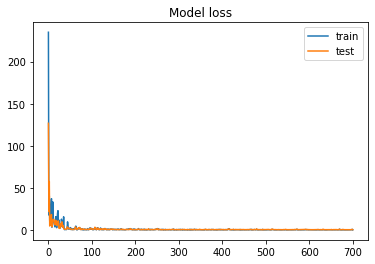

In [12]:
# Loss 값 plot
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Model loss')
plt.legend(loc= 'upper right')
plt.show()